# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Boston Housing data set.

## Objectives

You will be able to:
- Understand what interactions are
- Understand how to accommodate for interactions in regression

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Import the Boston data set using `load_boston()`. We won't bother to preprocess the data in this lab. If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()
boston = load_boston() # sklean module

Create a baseline model which includes all the variables in the Boston housing data set to predict the house prices. The use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [3]:
## code here
y = pd.DataFrame(boston.target, columns= ['target'])
df = pd.DataFrame(boston.data, columns = boston.feature_names)
all_data = pd.concat([y, df], axis=1)

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1) # 10 folds with replacement
baseline = np.mean(cross_val_score(regression, df, y, scoring='r2', cv=crossvalidation))
# model on 10 folds and then get mean


In [4]:
baseline

0.719010682018947

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the R^2. We'll look at the 3 interactions which have the biggest effect on our R^2, so print out the top 3 combinations.

You will create a for loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

In [5]:
from itertools import combinations
combinations = list(combinations(boston.feature_names, 2))

In [6]:
## code to find top 3 interactions by R^2 value here
interactions = []
data = df.copy()
for comb in combinations:
    data["interaction"] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring="r2", cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score,3)))
            
print("Top 3 interactions: %s" %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5])

Top 3 interactions: [('RM', 'LSTAT', 0.786), ('RM', 'TAX', 0.775), ('RM', 'RAD', 0.768), ('RM', 'PTRATIO', 0.763), ('INDUS', 'RM', 0.758)]


## Look at the top 3 interactions: "RM" as a confounding factor

The top three interactions seem to involve "RM", the number of rooms as a confounding variable for all of them. Let's have a look at interaction plots for all three of them. This exercise will involve:

- splitting our data up in 3 groups: one for houses with a few rooms, one for houses with a "medium" amount of rooms, one for a high amount of rooms.
- Create a function `build_interaction_rm`. This function takes an argument `varname` (which can be set equal to the column name as a string) and a column `description` (which describes the variable or varname, to be included on the x-axis of the plot). The function outputs a plot that uses "RM" as a confounding factor. 

We split the data set for high, medium and low amount of rooms for you.

In [7]:
rm = np.asarray(df[["RM"]]).reshape(len(df[["RM"]]))
rm

array([6.575, 6.421, 7.185, 6.998, 7.147, 6.43 , 6.012, 6.172, 5.631,
       6.004, 6.377, 6.009, 5.889, 5.949, 6.096, 5.834, 5.935, 5.99 ,
       5.456, 5.727, 5.57 , 5.965, 6.142, 5.813, 5.924, 5.599, 5.813,
       6.047, 6.495, 6.674, 5.713, 6.072, 5.95 , 5.701, 6.096, 5.933,
       5.841, 5.85 , 5.966, 6.595, 7.024, 6.77 , 6.169, 6.211, 6.069,
       5.682, 5.786, 6.03 , 5.399, 5.602, 5.963, 6.115, 6.511, 5.998,
       5.888, 7.249, 6.383, 6.816, 6.145, 5.927, 5.741, 5.966, 6.456,
       6.762, 7.104, 6.29 , 5.787, 5.878, 5.594, 5.885, 6.417, 5.961,
       6.065, 6.245, 6.273, 6.286, 6.279, 6.14 , 6.232, 5.874, 6.727,
       6.619, 6.302, 6.167, 6.389, 6.63 , 6.015, 6.121, 7.007, 7.079,
       6.417, 6.405, 6.442, 6.211, 6.249, 6.625, 6.163, 8.069, 7.82 ,
       7.416, 6.727, 6.781, 6.405, 6.137, 6.167, 5.851, 5.836, 6.127,
       6.474, 6.229, 6.195, 6.715, 5.913, 6.092, 6.254, 5.928, 6.176,
       6.021, 5.872, 5.731, 5.87 , 6.004, 5.961, 5.856, 5.879, 5.986,
       5.613, 5.693,

In [8]:
high_rm = all_data[rm > np.percentile(rm, 67)]
med_rm = all_data[(rm > np.percentile(rm, 33)) & (rm <= np.percentile(rm, 67))]
low_rm = all_data[rm <= np.percentile(rm, 33)]

Create `build_interaction_rm`.

In [9]:
def build_interaction_rm(varname, description):
    # fit three models, one for each partition of rm with a certain feature and the target
    regression_h = LinearRegression()
    regression_m = LinearRegression()
    regression_l = LinearRegression()
    regression_h.fit(high_rm[varname].values.reshape(-1, 1), high_rm["target"]) # why use reshape here?
    regression_m.fit(med_rm[varname].values.reshape(-1, 1), med_rm["target"])
    regression_l.fit(low_rm[varname].values.reshape(-1, 1), low_rm["target"])

    # Make predictions using the testing set
    pred_high = regression_h.predict(high_rm[varname].values.reshape(-1, 1))
    pred_med = regression_m.predict(med_rm[varname].values.reshape(-1, 1))
    pred_low = regression_l.predict(low_rm[varname].values.reshape(-1, 1))

    # The coefficients
    print(regression_h.coef_)
    print(regression_m.coef_)
    print(regression_l.coef_)

    # Plot outputs
    plt.figure(figsize=(12,7))
    plt.scatter(high_rm[varname], high_rm["target"],  color='blue', alpha = 0.3, label = "more rooms")
    plt.scatter(med_rm[varname], med_rm["target"],  color='red', alpha = 0.3, label = "medium rooms")
    plt.scatter(low_rm[varname], low_rm["target"],  color='orange', alpha = 0.3, label = "low amount of rooms")

    plt.plot(low_rm[varname], pred_low,  color='orange', linewidth=2)
    plt.plot(med_rm[varname], pred_med,  color='red', linewidth=2)
    plt.plot(high_rm[varname], pred_high,  color='blue', linewidth=2)
    plt.ylabel("house value")
    plt.xlabel(description)
    plt.legend()

Next, use build_interaction_rm with the three variables that came out with the highest effect on $R^2$

[-1.46614438]
[-0.67588205]
[-0.51981339]


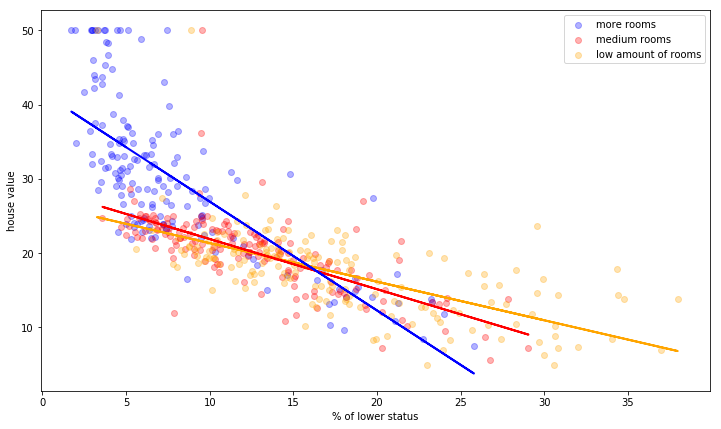

In [10]:
# first plot
build_interaction_rm("LSTAT", "% of lower status")

[-0.66803793]
[-0.24276834]
[-0.17393132]


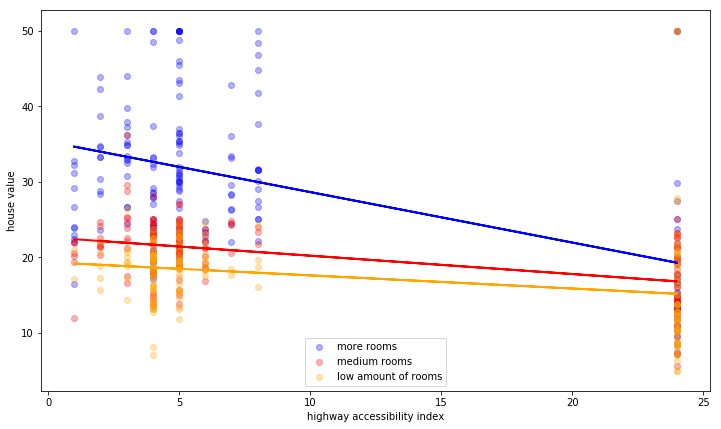

In [11]:
# second plot
build_interaction_rm("RAD","highway accessibility index")

[-0.03708037]
[-0.01431143]
[-0.01166035]


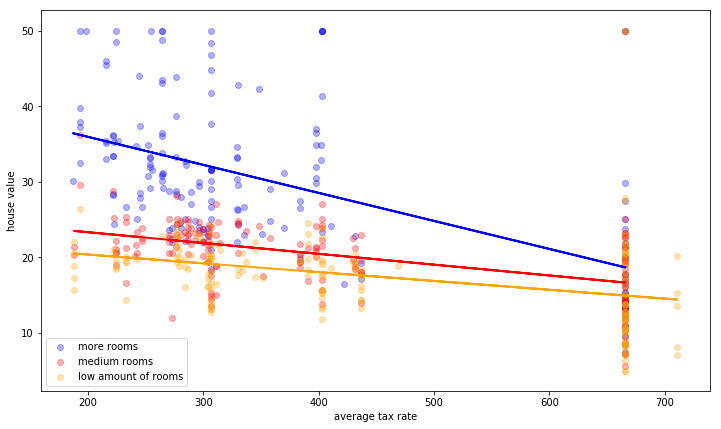

In [12]:
# third plot
build_interaction_rm("TAX", "average tax rate")

## Build a final model including all three interactions at once

Use 10-fold crossvalidation.

In [13]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [14]:
df_inter = df.copy()
for col in df_inter.columns:
    df_inter[col] = df_inter[col] - df_inter[col].mean()

In [15]:
# code here
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, random_state=1, shuffle=True)

df_inter['RM_LSTAT'] = df['RM'] * df['LSTAT']
df_inter['RM_TAX'] = df['RM'] * df['TAX']
df_inter['RM_RAD'] = df['RM'] * df['RAD']

final_model = np.mean(cross_val_score(regression, df_inter, y, scoring='r2', cv=crossvalidation))

In [16]:
df_inter.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,RM_LSTAT,RM_TAX,RM_RAD
0,-3.607204,6.636364,-8.826779,-0.06917,-0.016695,0.290366,-3.374901,0.294957,-8.549407,-112.237154,-3.155534,40.225968,-7.673063,32.74350,1946.200,6.575
1,-3.586214,-11.363636,-4.066779,-0.06917,-0.085695,0.136366,10.325099,1.172057,-7.549407,-166.237154,-0.655534,40.225968,-3.513063,58.68794,1553.882,12.842
2,-3.586234,-11.363636,-4.066779,-0.06917,-0.085695,0.900366,-7.474901,1.172057,-7.549407,-166.237154,-0.655534,36.155968,-8.623063,28.95555,1738.770,14.370
3,-3.581154,-11.363636,-8.956779,-0.06917,-0.096695,0.713366,-22.774901,2.267157,-6.549407,-186.237154,0.244466,37.955968,-9.713063,20.57412,1553.556,20.994
4,-3.544474,-11.363636,-8.956779,-0.06917,-0.096695,0.862366,-14.374901,2.267157,-6.549407,-186.237154,0.244466,40.225968,-7.323063,38.09351,1586.634,21.441


In [17]:
# code here
final_model

0.7852890964511969

Our $R^2$ has increased considerably! Let's have a look in statsmodels to see if all these interactions are significant.

In [18]:
# code here
import statsmodels.api as sm
df_inter_sm = sm.add_constant(df_inter)
model = sm.OLS(y,df_inter_sm)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     134.3
Date:                Thu, 06 Dec 2018   Prob (F-statistic):          3.25e-167
Time:                        10:30:38   Log-Likelihood:                -1413.9
No. Observations:                 506   AIC:                             2862.
Df Residuals:                     489   BIC:                             2934.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.2606      5.895     11.411      0.000      55.679      78.842
CRIM          -0.1628      0.028     -5.756      0.000      -0.218      -0.107
ZN             0.0174      0.012      1.463      0.144      -0.006       0.041
INDUS          0.0900      0.053      1.707      0.088      -0.014       0.194
CHAS           2.5988      0.740      3.511      0.000       1.144       4.053
NOX          -13.4647      3.277     -4.109      0.000     -19.903      -7.026
RM            10.8250      0.986     10.976      0.000       8.887      12.763
AGE            0.0052      0.011      0.461      0.645      -0.017       0.028
DIS           -0.9547      0.175     -5.469      0.000      -1.298      -0.612
RAD            0.7093      0.476      1.489      0.137      -0.227       1.645
TAX            0.0333      0.025      1.354      0.176      -0.015       0.082
PTRATIO       -0.6849      0.113     -6.068      0.000      -0.907      -0.463
B              0.0048      0.002      2.068      0.039       0.000       0.009
LSTAT          1.1528      0.232      4.973      0.000       0.697       1.608
RM_LSTAT      -0.2916      0.041     -7.169      0.000      -0.372      -0.212
RM_TAX        -0.0072      0.004     -1.828      0.068      -0.015       0.001
RM_RAD        -0.0699      0.078     -0.896      0.371      -0.223       0.083
==============================================================================
Omnibus:                      255.231   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2564.486
Skew:                           1.963   Prob(JB):                         0.00
Kurtosis:                      13.307   Cond. No.                     9.10e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is your conclusion here?

In [19]:
# formulate your conclusion

## Summary

You now understand how to include interaction effects in your model!